# Mounting to the Drive and loading packages

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
import sys, importlib, os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils
from typing import Tuple
import yaml
from pathlib import Path
from datetime import datetime

In [3]:
# Importing project packages
cwd = Path(os.getcwd())
root_dir = cwd.parent

utils_dir = root_dir.joinpath('src','utils')
weights_dir = root_dir.joinpath('checkpoints','weights')
model_dir = root_dir.joinpath('src','model')

# Making packages importable
sys.path.append(str(root_dir))

In [4]:
from src.utils import subVP_SDE, subVP_processes
from src.models import unet_model, components

importlib.reload(subVP_SDE)
importlib.reload(subVP_processes)
importlib.reload(components)
importlib.reload(unet_model)

from src.utils.subVP_SDE import subVP_SDE
from src.utils.subVP_processes import DiffusionProcesses
from src.models.components import SinusoidalPositionEmbeddings # Required by unet_model
from src.models.unet_model import UNet

# Weights to test

In [5]:
weights_name = "LDM_final_T1000_LR00003_E100_SA.pth"

# Defining `ReverseConfig`

In [6]:
# --- 1. Placeholder ReverseConfig Class ---
# This class is imported by subVP_processes.py.
# Default values are now loaded from the YAML config.
class ReverseConfig:
    def __init__(self,
                 shape: Tuple[int, int, int, int],
                 steps: int = 1000,
                 beta_min: float = 0.1,
                 beta_max: float = 20.0,
                 N: int = 1000,
                 device: torch.device = torch.device('cpu'),
                 dtype: torch.dtype = torch.float32,
                 seed: int = 42,
                 t0: float = 1.0,  # Start from t=1
                 t1: float = 1e-3, # Go to t=eps
                 rev_type: str = "sde", # "sde" or "ode"
                 n_corr: int = 0,
                 target_snr: float = 0.16
                 ):
        self.shape = shape
        self.steps = steps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.N = N
        self.device = device
        self.dtype = dtype
        self.seed = seed
        self.t0 = t0
        self.t1 = t1
        self.rev_type = rev_type
        self.n_corr = n_corr
        self.target_snr = target_snr

# Defyning loading and showing functions

In [7]:
def _extract_state_dict(ckpt):
    for k in ("state_dict", "model", "ema", "model_state_dict"):
        if isinstance(ckpt, dict) and k in ckpt and isinstance(ckpt[k], dict):
            return ckpt[k]
    return ckpt

def _strip_prefixes(sd: dict) -> dict:
    if any(k.startswith("module.") for k in sd):
        sd = {k.split("module.", 1)[1] if k.startswith("module.") else k: v for k, v in sd.items()}
    if all(k.startswith("unet.") for k in sd):
        sd = {k[len("unet."):]: v for k, v in sd.items()}
    return sd

def load_model_from_local(model: nn.Module, ckpt_path: str, device: torch.device) -> bool:
    """Load checkpoint from local filesystem instead of Google Drive."""
    if not os.path.isfile(ckpt_path):
        print(f"Error: Checkpoint not found at {ckpt_path}")
        return False
    print(f"Loading model weights from {ckpt_path} ...")

    try:
        ckpt = torch.load(ckpt_path, map_location="cpu")
    except Exception as e:
        print(f"[torch.load] failed: {e}")
        return False

    sd = _extract_state_dict(ckpt)
    sd = _strip_prefixes(sd)

    model_keys = set(model.state_dict().keys())
    filtered = {k: v for k, v in sd.items() if k in model_keys}

    dropped = sorted(k for k in sd.keys() if k not in model_keys)
    if dropped:
        print(f"Dropping {len(dropped)} unexpected keys (showing up to 8):")
        for k in dropped[:8]:
            print("  ", k)
        if len(dropped) > 8:
            print("  ...")

    res = model.load_state_dict(filtered, strict=False)
    print(f"Loaded. missing={len(res.missing_keys)} unexpected={len(res.unexpected_keys)}")

    model.to(device).eval()
    return True
    return True


# --- 3. Image Plotting Utility ---
def show_images(images: torch.Tensor, title: str = "", save_path: str = None):
    """
    Displays a grid of images.
    Input images are assumed to be in range [-1, 1] or [0, 1].
    """
    # Detach from graph, move to CPU
    images = images.detach().cpu()

    # Create a grid
    grid = torchvision.utils.make_grid(
        images,
        nrow=int(images.shape[0]**0.5), # Create a roughly square grid
        normalize=True,      # Automatically scales to [0, 1]
        value_range=(-1, 1), # Specify expected input range
        padding=2,
        pad_value=1.0 # White padding
    )

    # Convert to (H, W, C) for matplotlib
    grid_np = grid.permute(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_np)
    plt.title(title)
    plt.axis("off")
    if save_path:
        plt.savefig(save_path)
        print(f"Image grid saved to {save_path}")
    plt.show()

# Setting configuarations and loading model

In [8]:
# --- Directories ---
cwd = Path(os.getcwd())
root_dir = cwd.parent
weights_dir = root_dir.joinpath('checkpoints', 'weights')

# --- Main Pipeline Execution ---
# DRIVE_FILE_ID = "1nFjiJcQH9vjYNI1HUKokdfmcbTfq7lpL"

# Build model/config paths using weights_dir and root_dir
MODEL_SAVE_PATH = weights_dir.joinpath(weights_name)
CONFIG_PATH = root_dir.joinpath("experiments", "base_config.yaml")

# Load parameters from config file
print(f"Loading configuration from {CONFIG_PATH}...")
try:
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
        print("Config file:", config)
except FileNotFoundError:
    print(f"Error: Config file not found at {CONFIG_PATH}")
    exit(1)
except Exception as e:
    print(f"Error loading YAML config: {e}")
    exit(1)

# Model parameters from config
LATENT_CHANNELS = config.get('latent_channels', 4)
FEATURES = config.get('features', [128, 256, 512])

# SDE parameters from config
BETA_MIN = config.get('beta_min', 0.1)
BETA_MAX = config.get('beta_max', 20.0)
N_TIMESTEPS = config.get('n_timesteps', 1000)

# Pipeline parameters
BATCH_SIZE = 2
SAMPLING_STEPS = 1000
IMAGE_SIZE = 32

Loading configuration from C:\Users\Lenovo\Documents\SCUOLA\UNI\MASTER\2ANNO\HANDS ON GENERATIVE AI\Hands-on-Generative-AI\experiments\base_config.yaml...
Config file: {'epochs': 50, 'learning_rate': 0.0001, 'batch_size': 64, 'model': 'LDM', 'n_timesteps': 1000, 'beta_min': 0.1, 'beta_max': 20.0, 'use_importance_sampling': True, 'latent_channels': 4, 'image_size': 128, 'vae_scale_factor': 0.18215, 'validation_split_ratio': 0.2, 'features': [128, 256, 512], 'self_attention': True, 'num_workers': 0, 'data_path': './data/coco2017/train2017'}


In [9]:
# Set up configuration for the reverse process
cfg = ReverseConfig(
    shape=(BATCH_SIZE, LATENT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
    steps=SAMPLING_STEPS,
    beta_min=BETA_MIN,
    beta_max=BETA_MAX,
    N=N_TIMESTEPS,
    rev_type="sde"
)

# --- 2. Setup Device and Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg.device = device
print(f"Using device: {device}")

# Instantiate the REAL Unet model from unet_model.py
print("Instantiating UNet model...")
model = UNet(
    in_channels=LATENT_CHANNELS,
    out_channels=LATENT_CHANNELS,
    features=FEATURES
    # time_emb_dim and num_blocks use defaults from unet_model.py
)
print("Instanzato bello!")

Using device: cpu
Instantiating UNet model...
Instanzato bello!


# Checking models and weights compatability

In [10]:
# build your model with the SAME hyperparams used for training
# model = UNet(in_channels=LATENT_CHANNELS, out_channels=LATENT_CHANNELS, features=FEATURES)

# missing, unexpected, shape_bad = diff_weights_vs_model(model, MODEL_SAVE_PATH)

In [11]:
# print(model)
# # Or drill into the exact submodules:
# for i in (0, 1):
#     try:
#         m = model.get_submodule(f"bottleneck.{i}")
#         print(f"\n[bottleneck.{i}] ->", type(m).__name__)
#         for n, _ in m.named_parameters(recurse=False):
#             print("  param:", n)
#         for n, _ in m.named_buffers(recurse=False):
#             print("  buffer:", n)
#         # If bottleneck.{i} is a Sequential, list children:
#         for n, c in m.named_children():
#             print("  child:", n, type(c).__name__)
#     except Exception as e:
#         print(f"bottleneck.{i} not found:", e)

# Loading and rest

In [12]:
# --- 3. Load Weights ---
ckpt_path = weights_dir.joinpath(weights_name)
load_model_from_local(model, ckpt_path, device)

Loading model weights from C:\Users\Lenovo\Documents\SCUOLA\UNI\MASTER\2ANNO\HANDS ON GENERATIVE AI\Hands-on-Generative-AI\checkpoints\weights\LDM_final_T1000_LR00003_E100_SA.pth ...
Loaded. missing=0 unexpected=0


True

# Diffusion reverse samplign

Starting reverse sampling for (2, 4, 32, 32)...
Summary stats:
Steps done: 0
Time of last 100 steps: 0.0
Average time of last 100 steps: 0.0
Overall time:0.0
Summary stats:
Steps done: 100
Time of last 100 steps: 9.289593696594238
Average time of last 100 steps: 0.09289593696594238
Overall time:9.289593696594238
Summary stats:
Steps done: 200
Time of last 100 steps: 8.967729330062866
Average time of last 100 steps: 0.08967729330062867
Overall time:18.257323026657104
Summary stats:
Steps done: 300
Time of last 100 steps: 8.873557567596436
Average time of last 100 steps: 0.08873557567596435
Overall time:27.13088059425354
Summary stats:
Steps done: 400
Time of last 100 steps: 8.904977321624756
Average time of last 100 steps: 0.08904977321624756
Overall time:36.035857915878296
Summary stats:
Steps done: 500
Time of last 100 steps: 8.891005992889404
Average time of last 100 steps: 0.08891005992889404
Overall time:44.9268639087677
Summary stats:
Steps done: 600
Time of last 100 steps: 8.8773

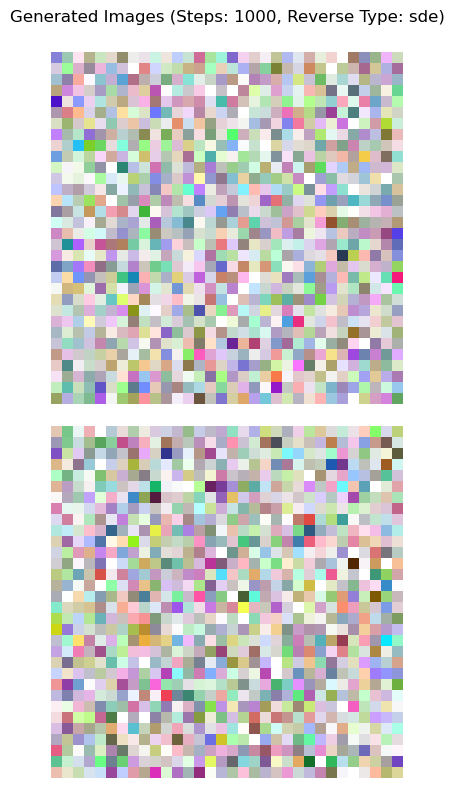

In [16]:
# --- 4. Initialize Diffusion Process ---
# Pass SDE parameters from config
diff_process = DiffusionProcesses(
    beta_min=cfg.beta_min,
    beta_max=cfg.beta_max,
    N=cfg.N,
    schedule="linear"
)

details = f"{cfg.N}_steps_{cfg.rev_type}_"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

file_name = f"denoised_{details}_{timestamp}.png"
denoised_path = os.path.join("..","images",file_name)

# --- 5. Run Reverse Process ---
print(f"Starting reverse sampling for {cfg.shape}...")
# The 'sample_reverse' function is part of the DiffusionProcesses instance
generated_images = diff_process.sample_reverse(cfg, model)
print("Sampling complete.")

# --- 6. Visualize Results ---
show_images(generated_images,
            title = f"Generated Images (Steps: {cfg.steps}, Reverse Type: {cfg.rev_type})",
            save_path = denoised_path)

# Decoding

In [17]:
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(next(model.parameters()).device).eval()
VAE_SCALE_FACTOR = vae.config.scaling_factor

In [18]:
def decode_from_latent(latents: torch.Tensor):
    """Converte latenti in pixel [0, 1]."""
    latents = latents / VAE_SCALE_FACTOR
    with torch.no_grad():
        image = vae.decode(latents).sample
    return (image / 2 + 0.5).clamp(0, 1)

In [19]:
generated_images = generated_images.to(next(vae.parameters()).device, dtype=torch.float32)

Decoded image grid saved to ..\images\decoded_1000_steps_sde__20251120_175108.png


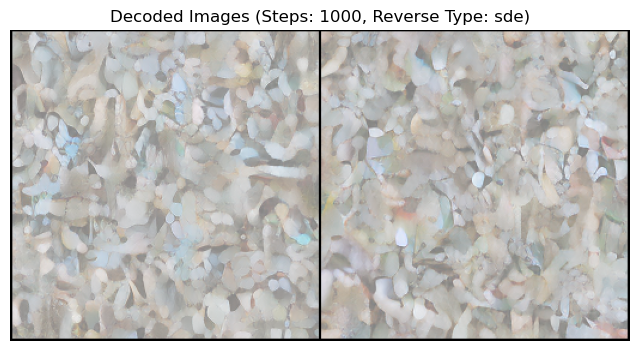

In [20]:
decoded = decode_from_latent(generated_images)

decoded_name = f"decoded_{details}_{timestamp}.png"
decoded_path = os.path.join("..", "images", decoded_name)

grid = torchvision.utils.make_grid(decoded, nrow=4, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(f"Decoded Images (Steps: {cfg.steps}, Reverse Type: {cfg.rev_type})")


plt.savefig(decoded_path, bbox_inches="tight")
print(f"Decoded image grid saved to {decoded_path}")
plt.show()